In [1]:
import envs.frame_generator as frame_generator
import envs.constant_frame_generator as constant_frame_generator
import envs.random_frame_generator as random_frame_generator
from envs.frame_generator_delayed import FrameGeneratorDelayed
from utils.layer_output_calculator import LayerOutputCalculator
from utils.layer_output_calculator_delayedtarget import LayerOutputCalculatorDelayedTarget
from sb3model_wrappers.recurrentppo_wrapper import sb3Wrapper
from utils.neural_importance import get_extreme_weight_neurons, get_topn_neurons_per_action
from utils.neural_oscillations import plot_hidden_state, fft, pca

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import torch as t
import random

In [3]:
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

In [4]:
TRAIN_VIDEO_PATH = "videos/V1-0001_City Scene Layout 1 setting0001.mp4"
VIDEO_FPS = 24
FRAME_SIZE = (124,124)
N_EPISODES = 50000
target_duration = 4

In [5]:
env_delayed = FrameGeneratorDelayed(TRAIN_VIDEO_PATH, TRAIN_VIDEO_PATH,VIDEO_FPS, FRAME_SIZE, n_episodes=N_EPISODES, target_duration=target_duration)

In [11]:
check_env(env_delayed)

In [6]:
env_test = env_delayed

_, obs = env_test.reset()

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))  # Create two subplots

# Initialize images for both subplots
image_axes_1 = ax1.imshow(env_test.video_frames[0], cmap='viridis')


plt.close()  # Prevent duplicate static display in Jupyter Notebook

# Function to update both images
def update_mask(j):
    image_axes_1.set_array(env_test.video_frames[j])
    return [image_axes_1]

# Create the animation
animated_hands = FuncAnimation(fig, update_mask, frames=range(len(env_test.video_frames)), blit=True)

# Display the animation
HTML(animated_hands.to_jshtml())


In [9]:
env_test.cue_frame_position, len(env_test.video_frames)

(13, 41)

In [12]:
if __name__ == "__main__":

    obs, _ = env_test.reset()

    print(env_test.target_duration)
    rewards = 0
    while True:
        action = int(input("Enter action (0 for go, 1 for stop): "))
        obs, reward, done, _,_= env_test.step(action)
        print("reward",reward, "step", env_test.current_frame_index)
        rewards += reward
        if done:
            print(env_test.target_duration)
            print(rewards,"reward")
            break

4


Enter action (0 for go, 1 for stop):  0


reward 0 step 1


Enter action (0 for go, 1 for stop):  1


reward 0 step 2


Enter action (0 for go, 1 for stop):  1


reward 0 step 3


Enter action (0 for go, 1 for stop):  0


reward 0 step 4


Enter action (0 for go, 1 for stop):  1


reward 0 step 5


Enter action (0 for go, 1 for stop):  0


reward 0 step 6


Enter action (0 for go, 1 for stop):  1


reward 0 step 7


Enter action (0 for go, 1 for stop):  0


reward 0 step 8


Enter action (0 for go, 1 for stop):  1


reward 0 step 9


Enter action (0 for go, 1 for stop):  1


reward 0 step 10


Enter action (0 for go, 1 for stop):  1


reward 0 step 11


Enter action (0 for go, 1 for stop):  1


reward 0 step 12


Enter action (0 for go, 1 for stop):  1


reward 0 step 13


Enter action (0 for go, 1 for stop):  1


reward 0 step 14


Enter action (0 for go, 1 for stop):  1


reward 0 step 15


Enter action (0 for go, 1 for stop):  1


reward 0 step 16


Enter action (0 for go, 1 for stop):  1


reward 0 step 17


Enter action (0 for go, 1 for stop):  1


reward -1 step 18


Enter action (0 for go, 1 for stop):  0


reward 0 step 19


Enter action (0 for go, 1 for stop):  0


reward 0 step 20


Enter action (0 for go, 1 for stop):  0


reward -1 step 21


Enter action (0 for go, 1 for stop):  0


reward 0 step 22


Enter action (0 for go, 1 for stop):  0


reward 0 step 23


Enter action (0 for go, 1 for stop):  1


reward -1 step 24


Enter action (0 for go, 1 for stop):  1


reward 1 step 25


Enter action (0 for go, 1 for stop):  0


reward 0 step 26


Enter action (0 for go, 1 for stop):  0


reward 0 step 27


Enter action (0 for go, 1 for stop):  0


reward 0 step 28


Enter action (0 for go, 1 for stop):  1


reward 1 step 29


Enter action (0 for go, 1 for stop):  1


reward -1 step 30


Enter action (0 for go, 1 for stop):  0


reward 0 step 31


Enter action (0 for go, 1 for stop):  0


reward 0 step 32


Enter action (0 for go, 1 for stop):  1


reward 1 step 33


Enter action (0 for go, 1 for stop):  0


reward 0 step 34


Enter action (0 for go, 1 for stop):  0


reward 0 step 35


Enter action (0 for go, 1 for stop):  0


reward 0 step 36


Enter action (0 for go, 1 for stop):  0


reward -1 step 37


Enter action (0 for go, 1 for stop):  0


reward 0 step 38


Enter action (0 for go, 1 for stop):  1


reward -1 step 39


Enter action (0 for go, 1 for stop):  1


reward -1 step 40


Enter action (0 for go, 1 for stop):  1


reward 1 step 41
4


AttributeError: 'FrameGeneratorDelayed' object has no attribute 'achieved_goal'

In [130]:

def get_info_for_neural_oscillation(wrapped_model_durt, model_durt, env_durt,
                                    video_path="videos/V1-0001_City Scene Layout 1 setting0001.mp4", model_path = 'models/sb3_ppo_1goal_rnn_multistop_multiseq', 
                                    video_fps=24, frame_size=(124,124), target_duration=4, process_layer_output=True, threshold=2 ):
    
    if process_layer_output:

        
        targett_output_calculator = LayerOutputCalculatorDelayedTarget(wrapped_model_durt, model_durt, env_durt)
        targett_output_calculator.get_layer_outputs_per_episode()

        action_weights = model_durt.policy.state_dict()["action_net.weight"]
        high_z_indices, low_z_indices = get_extreme_weight_neurons(action_weights,threshold)
        topn_action_weights = get_topn_neurons_per_action(action_weights)

    else:
        targett_output_calculator = None
        action_weights = model_durt.policy.state_dict()["action_net.weight"]
        high_z_indices, low_z_indices = get_extreme_weight_neurons(action_weights,threshold)
        topn_action_weights = get_topn_neurons_per_action(action_weights)

    return targett_output_calculator, high_z_indices, low_z_indices, topn_action_weights

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def pca(squeezed_policy_layer, pca_components=3, total_timestep=20, save_path=None):
    scaler_policy = StandardScaler()

    policy_layer_scaled = scaler_policy.fit_transform(squeezed_policy_layer)

    pca_policy = PCA(n_components=pca_components)

    policy_layer_pc = pca_policy.fit_transform(policy_layer_scaled)

    explained_variance_policy = pca_policy.explained_variance_ratio_

    print("explained_variance policy", explained_variance_policy)

    plt.figure(figsize=(12, 4))
    colors = ['royalblue', 'deepskyblue', 'goldenrod']
    for i in range(policy_layer_pc.shape[1]):
        plt.plot(policy_layer_pc[:, i], marker='o', label=f'PC {i+1} ({round(explained_variance_policy[i]*100)}%)', alpha=0.8, color=colors[i])
    
    cue_onset_frame = 19
    plt.axvline(x=cue_onset_frame, color='red', linestyle='--', linewidth=2, label='Cue Frame Onset')

    ax = plt.gca()
    # for spine in ['top', 'right']:
    #     ax.spines[spine].set_visible(False)
        
    # plt.title("Principal component analysis (PCA) of LSTM Hidden States Over Time", fontsize=14)
    plt.xlabel("Time Step", fontsize=12)
    # plt.ylabel("Principal Component Value", fontsize=12)
    plt.xticks(range(policy_layer_pc.shape[0]))
    plt.legend(loc='lower right', frameon=False, fontsize=10)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    return policy_layer_pc


def fft(squeezed_policy_layer, high_z_indices, low_z_indices, save_path=None):
    # N - number of neurons
    # T - time steps
    squeezed_policy_layer_NT = squeezed_policy_layer.T  # Shape: (N, T)

    # Apply FFT to each neuron's time series
    fft_policy_results = np.fft.rfft(squeezed_policy_layer_NT, axis=1)
    fft_policy_magnitudes = np.abs(fft_policy_results)

    # Compute frequency bins
    time_steps = squeezed_policy_layer.shape[0]
    sampling_rate = 1  # 1 sample per timestep;
    freqs = np.fft.rfftfreq(time_steps, d=1 / sampling_rate)

    plt.figure(figsize=(8, 4))

    for i in range(squeezed_policy_layer.shape[1]):
        if i in high_z_indices:
            plt.plot(freqs[:time_steps // 1 ], fft_policy_magnitudes[i, :time_steps // 1], color="blue", marker="o")
            print(freqs[:time_steps // 1 ], fft_policy_magnitudes[i, :time_steps // 1])
        elif i in low_z_indices:
            plt.plot(freqs[:time_steps // 1], fft_policy_magnitudes[i, :time_steps // 1], color="red", marker="o")
        else:
            plt.plot(freqs[:time_steps // 1], fft_policy_magnitudes[i, :time_steps // 1], marker="o", alpha=0.05,
                     color="lightgrey", linestyle="--")

        # break

    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Magnitude", fontsize=12)
    plt.xticks(np.arange(0, 0.55, 0.05))
    plt.ylim(0, 15)
    plt.tight_layout()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [19]:
# duration = 4
video_path="videos/V1-0001_City Scene Layout 1 setting0001.mp4"
model_path = 'models/sb3_ppo_1goal_rnn_multistop_multiseq_delayedtarget4'
target_duration = 4

env_durt = FrameGeneratorDelayed(video_path, video_path, 24, (124,124),
                                     n_episodes=10, target_duration=target_duration)
# model_durt = RecurrentPPO.load(model_path, env=env_durt)
# model_modified1 = RecurrentPPO.load(model_path, env=env_durt)

# wrapped_model_durt = sb3Wrapper(model_durt)

target4_output_calculator, high_z_indices_dur4, low_z_indices_dur4, topn_action_weights_dur4 = get_info_for_neural_oscillation(wrapped_model_durt, model_durt, env_durt, video_path=video_path, model_path=model_path, target_duration=target_duration, threshold=2)
# _, high_z_indices_dur4, low_z_indices_dur4, topn_action_weights_dur4 = get_info_for_neural_oscillation(wrapped_model_durt, model_durt, env_durt, video_path=video_path, model_path=model_path, target_duration=target_duration, process_layer_output=False,threshold=2)
print("cue frame position", target4_output_calculator.cue_frame_position)

target time 4
current_frame_index 0
action 1
reward 0
current_frame_index 1
action 0
reward 0
current_frame_index 2
action 0
reward 0
current_frame_index 3
action 1
reward 0
current_frame_index 4
action 1
reward 0
current_frame_index 5
action 0
reward 0
current_frame_index 6
action 1
reward 0
current_frame_index 7
action 1
reward 0
current_frame_index 8
action 1
reward 0
current_frame_index 9
action 0
reward 0
current_frame_index 10
action 0
reward 0
current_frame_index 11
action 0
reward 0
current_frame_index 12
action 0
reward 0
current_frame_index 13
action 1
reward 0
current_frame_index 14
action 1
reward 0
current_frame_index 15
action 1
reward 0
current_frame_index 16
action 1
reward 0
current_frame_index 17
action 1
reward 0
current_frame_index 18
action 0
reward 0
current_frame_index 19
action 0
reward 0
current_frame_index 20
action 0
reward 0
current_frame_index 21
action 0
reward 0
current_frame_index 22
action 0
reward 0
current_frame_index 23
action 1
reward 1
current_fram

In [16]:
reward_list, episode_list =evaluate_policy(model_durt, env_durt,n_eval_episodes=100, deterministic = True, return_episode_rewards=True )
np.mean(reward_list)

C:\Users\Administrator\miniconda3\envs\overcooked_gpulab\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


np.float64(2.21)

# neural activation patterns in a delayed environment 

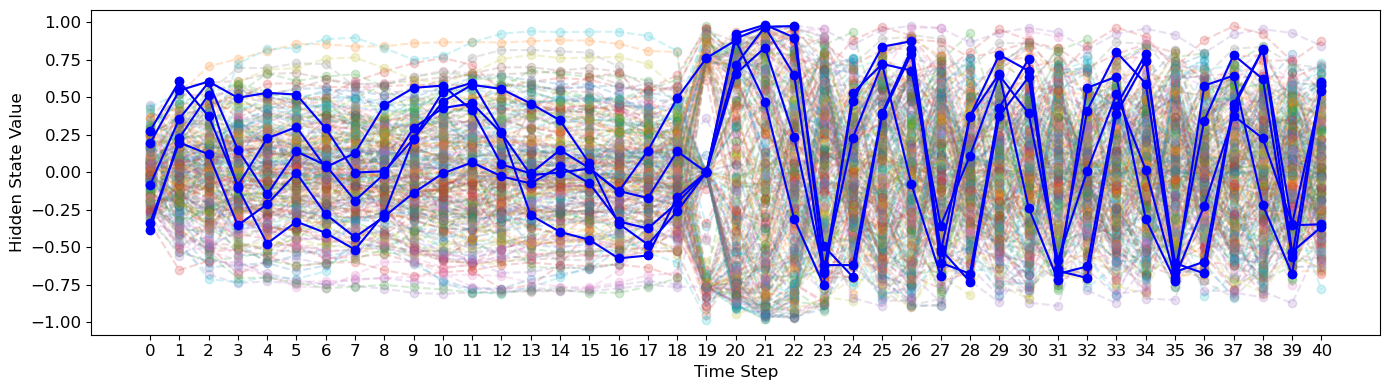

In [20]:
plot_hidden_state(target4_output_calculator.lstm_hidden, target4_output_calculator.lstm_cell, high_z_indices_dur4, low_z_indices_dur4, topn_action_weights_dur4[1])

In [ ]:
# action netwrok calculation 

In [78]:
len(target4_output_calculator.lstm_hidden), 
w_delta = (model_durt.policy.state_dict()["action_net.weight"][0,:] - model_durt.policy.state_dict()["action_net.weight"][1,:]).numpy()
b_delta = (model_durt.policy.state_dict()["action_net.bias"][0] - model_durt.policy.state_dict()["action_net.bias"][1]).numpy()

In [79]:
lstm_hidden = np.stack(target4_output_calculator.lstm_hidden)
lstm_hidden = lstm_hidden.squeeze(1).squeeze(1)
lstm_hidden.shape, w_delta.shape

((41, 256), (256,))

In [80]:
scores = lstm_hidden @ w_delta + b_delta
scores.shape

(41,)

In [84]:
np.array(target4_output_calculator.actions)

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0])

In [82]:
scores

array([-0.87055105,  3.5248435 ,  3.241574  , -1.0446604 , -0.9922652 ,
        0.04897717, -1.5741315 , -2.3514907 , -0.48333246,  1.6679128 ,
        3.0482743 ,  2.9024732 ,  0.82012606, -0.6971913 , -0.4031531 ,
       -1.1292027 , -2.8581007 , -2.5406258 ,  0.2760001 ,  6.675205  ,
       15.344162  , 15.0739155 ,  6.7860394 , -8.979185  ,  0.58933175,
       10.239057  ,  7.999316  , -7.729295  , -1.1585749 ,  8.279714  ,
        4.5112534 , -9.661203  , -0.25259638,  8.291789  ,  4.1063905 ,
       -9.824995  , -0.33165655,  8.2085705 ,  6.122018  , -5.9586554 ,
        2.9580953 ], dtype=float32)

In [85]:
# Predict actions
predicted_actions = (scores < 0).astype(int)

print("Predicted actions:", predicted_actions)

Predicted actions: [1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1
 0 0 1 0]


In [ ]:
# Predict actions 2 
predicted_actions = []
for i in range(31):
    predicted_actions.append(lstm_hidden[i, high_z_indices_dur4])

print("Predicted actions:", predicted_actions)

In [86]:
np.array(target4_output_calculator.actions) == predicted_actions

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [99]:
lstm_hidden[3, high_z_indices_dur4], lstm_hidden[40, low_z_indices_dur4]

(array([ 0.3500927 ,  0.15129435,  0.49675387, -0.10383006, -0.06757946,
         0.7236052 , -0.35333294, -0.08837343], dtype=float32),
 array([], dtype=float32))

In [101]:
lstm_hidden[21, high_z_indices_dur4], lstm_hidden[1, low_z_indices_dur4]

(array([-0.51014435,  0.96966857,  0.8315461 ,  0.9831786 , -0.11024711,
        -0.5375545 ,  0.96925455,  0.46996424], dtype=float32),
 array([], dtype=float32))

# fft and pca 

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421] [0.652013   2.085782   1.5889513  0.19399825 0.8750189  0.19577733
 0.80721515 0.4335445  0.30131525 0.2958331 ]
[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421] [2.1528258  0.5294017  2.2585783  0.4939212  1.0681473  0.8475555
 1.1886872  0.31980628 0.2438599  0.34907684]
[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421] [4.7976756  1.8042403  3.7926052  0.54646164 1.1769924  0.14530885
 0.16559927 0.0308555  0.01126034 0.06233517]
[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421] [2.5383954  1.4818306  4.424573   0.7705202  1.3701137  0.92234385
 1.2282315  0.49474272 0.3031661  0.39003387]
[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105

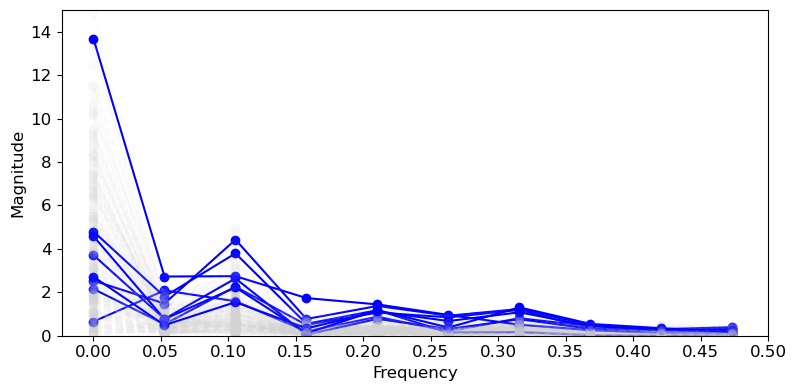

In [131]:
squeezed_lstm_policy = np.array(target4_output_calculator.lstm_hidden).squeeze(1).squeeze(1)[0:target4_output_calculator.cue_frame_position]
squeezed_lstm_value = np.array(target4_output_calculator.lstm_cell).squeeze(1).squeeze(1)
a = fft(squeezed_lstm_policy, high_z_indices_dur4, low_z_indices_dur4, save_path="fft_of_lstm_hidden_states_delayed_timing_1.png")

[0.         0.04761905 0.0952381  0.14285714 0.19047619 0.23809524
 0.28571429 0.33333333 0.38095238 0.42857143 0.47619048] [4.237388   2.5358617  1.1999749  1.5595253  2.5504708  5.9099298
 1.2501923  0.3266478  0.5273306  0.37996268 0.1595428 ]
[0.         0.04761905 0.0952381  0.14285714 0.19047619 0.23809524
 0.28571429 0.33333333 0.38095238 0.42857143 0.47619048] [1.588497   1.8711076  1.479551   1.5041494  2.0285635  8.49041
 2.871755   1.0629059  0.72208995 0.854426   1.351581  ]
[0.         0.04761905 0.0952381  0.14285714 0.19047619 0.23809524
 0.28571429 0.33333333 0.38095238 0.42857143 0.47619048] [3.32081    2.0636387  1.5706019  1.5572997  1.4819202  5.3814
 2.0679917  0.49152955 0.9654897  1.0216784  1.1616462 ]
[0.         0.04761905 0.0952381  0.14285714 0.19047619 0.23809524
 0.28571429 0.33333333 0.38095238 0.42857143 0.47619048] [1.6029801  2.4925766  1.578387   1.6404161  1.9400043  8.187635
 2.8177507  1.1921049  0.6739939  0.79211944 0.889954  ]
[0.         0.0476

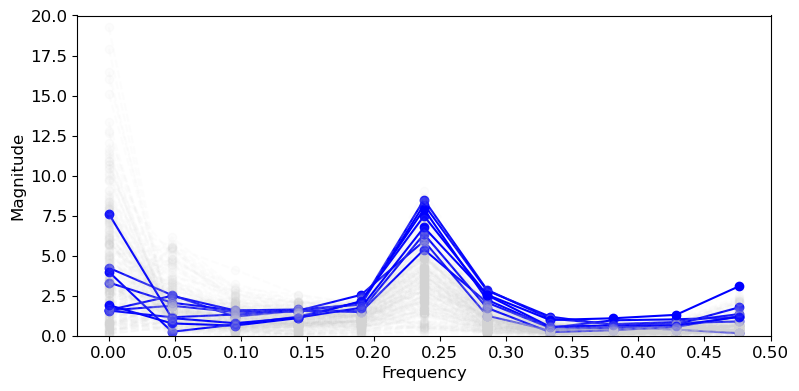

In [128]:
squeezed_lstm_policy = np.array(target4_output_calculator.lstm_hidden).squeeze(1).squeeze(1)[target4_output_calculator.cue_frame_position+1:]
squeezed_lstm_value = np.array(target4_output_calculator.lstm_cell).squeeze(1).squeeze(1)
fft(squeezed_lstm_policy, high_z_indices_dur4, low_z_indices_dur4, save_path ="fft_of_lstm_hidden_states_delayed_timing_2.png")

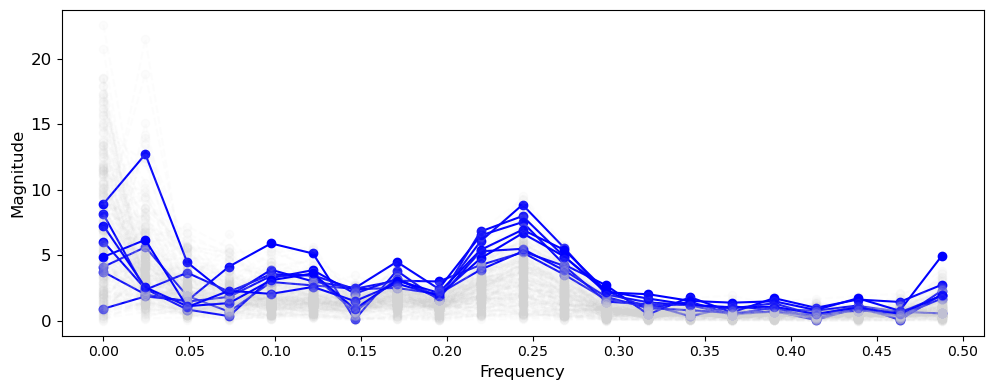

In [23]:
squeezed_lstm_policy = np.array(target4_output_calculator.lstm_hidden).squeeze(1).squeeze(1)
squeezed_lstm_value = np.array(target4_output_calculator.lstm_cell).squeeze(1).squeeze(1)
fft(squeezed_lstm_policy, high_z_indices_dur4, low_z_indices_dur4)

explained_variance policy [0.36628276 0.24062622 0.16685633]


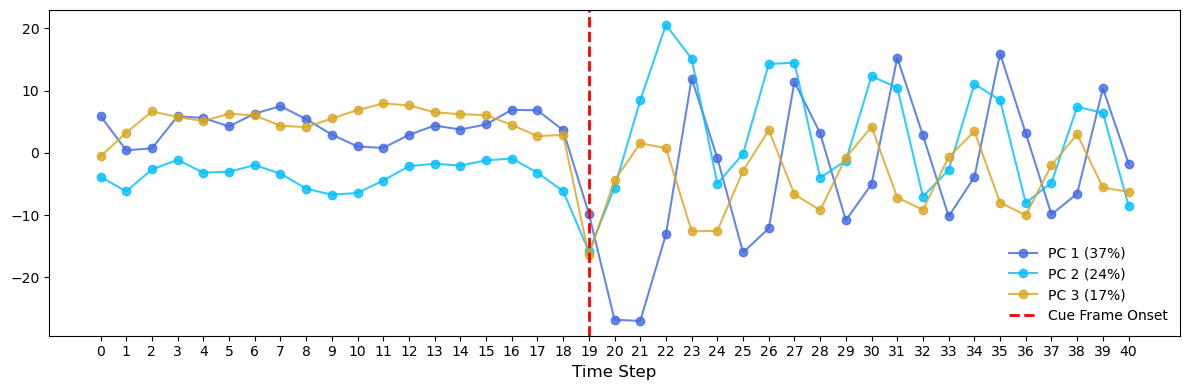

In [108]:
squeezed_lstm_policy = np.array(target4_output_calculator.lstm_hidden).squeeze(1).squeeze(1)
pca_dur4= pca(squeezed_lstm_policy, pca_components=3, save_path = "pca_delayed_time")

# How many oscillating neurons are needed for the model to perform well?

In [27]:
model_durt.policy.state_dict().keys()

odict_keys(['features_extractor.cnn.0.weight', 'features_extractor.cnn.0.bias', 'features_extractor.cnn.2.weight', 'features_extractor.cnn.2.bias', 'features_extractor.cnn.4.weight', 'features_extractor.cnn.4.bias', 'features_extractor.linear.0.weight', 'features_extractor.linear.0.bias', 'pi_features_extractor.cnn.0.weight', 'pi_features_extractor.cnn.0.bias', 'pi_features_extractor.cnn.2.weight', 'pi_features_extractor.cnn.2.bias', 'pi_features_extractor.cnn.4.weight', 'pi_features_extractor.cnn.4.bias', 'pi_features_extractor.linear.0.weight', 'pi_features_extractor.linear.0.bias', 'vf_features_extractor.cnn.0.weight', 'vf_features_extractor.cnn.0.bias', 'vf_features_extractor.cnn.2.weight', 'vf_features_extractor.cnn.2.bias', 'vf_features_extractor.cnn.4.weight', 'vf_features_extractor.cnn.4.bias', 'vf_features_extractor.linear.0.weight', 'vf_features_extractor.linear.0.bias', 'action_net.weight', 'action_net.bias', 'value_net.weight', 'value_net.bias', 'lstm_actor.weight_ih_l0', '

In [62]:
# neurons with high weights 
high_z_indices_dur4, low_z_indices_dur4, topn_action_weights_dur4

(array([ 30,  52, 126, 128, 154, 169, 233, 234]),
 array([], dtype=int64),
 {0: tensor([128, 234, 126, 233,  52, 156, 123,  40, 212, 131, 204,  86, 106,  95,
           36,  25, 238, 182, 237, 193]),
  1: tensor([169,  30, 154, 173, 163, 201, 104,   4,  45, 122, 189, 135,  76,   0,
          138,  59, 178, 113, 144, 179])})

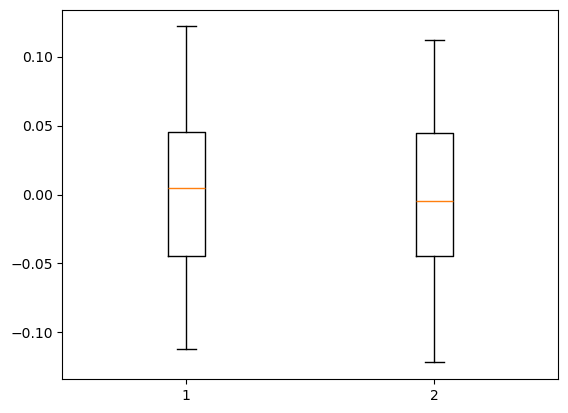

In [92]:
# weights distribution
b = plt.boxplot([model_durt.policy.state_dict()["action_net.weight"][0], model_durt.policy.state_dict()["action_net.weight"][1]])

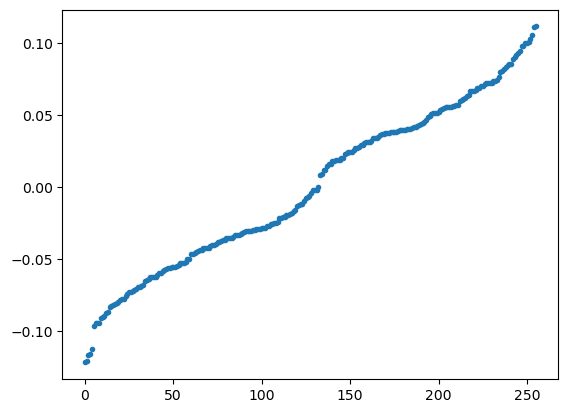

In [93]:
sorted_weights = sorted(model_durt.policy.state_dict()["action_net.weight"][1])
plt.plot(sorted_weights, ".")

In [56]:
model_durt.policy

RecurrentActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=9216, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=9216, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
  

In [89]:
# remove neuron with higher weight for action 1
model_modified1 = RecurrentPPO.load(model_path, env=env_durt)
neurons_to_disconnect = []
n_neurons_to_disconnect = 2
for i, n in enumerate(topn_action_weights_dur4[1]):
    neurons_to_disconnect.append(n)
    if i == n_neurons_to_disconnect -1:
        model_modified1.policy.state_dict()["action_net.weight"][1,neurons_to_disconnect] = 0
        reward_list, episode_list =evaluate_policy(model_modified1, env_durt,n_eval_episodes=100, deterministic = True, return_episode_rewards=True )
        print(np.mean(reward_list))
        break


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
2.39


In [109]:
# shuffle action weights 
model_modified1 = RecurrentPPO.load(model_path, env=env_durt)
a = model_modified1.policy.state_dict()["action_net.weight"][1]
random.shuffle(a)
model_modified1.policy.state_dict()["action_net.weight"][1] = a
reward_list, episode_list =evaluate_policy(model_modified1, env_durt,n_eval_episodes=100, deterministic = True, return_episode_rewards=True )
print(np.mean(reward_list))


C:\Users\Administrator\miniconda3\envs\overcooked_gpulab\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
C:\Users\Administrator\miniconda3\envs\overcooked_gpulab\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


C:\Users\Administrator\miniconda3\envs\overcooked_gpulab\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


2.13
